Let me show 40 different people.
images shape: (400, 64, 64), labels shape: (400,)


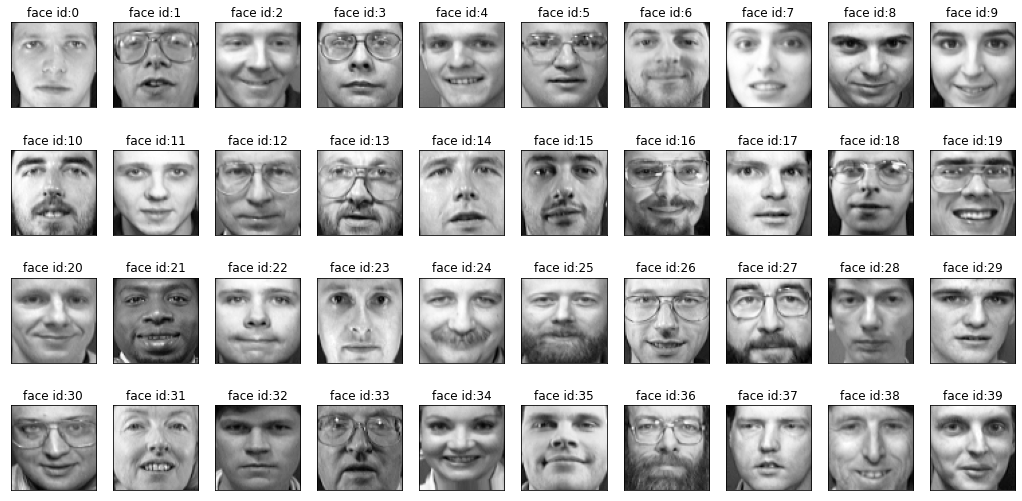

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

%matplotlib inline

olivetti = fetch_olivetti_faces()
images = olivetti.images
labels = olivetti.target

def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
        
print(f"Let me show {len(np.unique(labels))} different people.")
show_40_distinct_people(images, np.unique(labels))

print(f"images shape: {images.shape}, labels shape: {labels.shape}")

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=0,
                                                   stratify=labels, test_size=0.1)

print(len(X_train), len(X_test))

360 40


In [3]:
import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import PIL

compose = transforms.Compose([
    transforms.ToPILImage(), 
    torchvision.transforms.RandomHorizontalFlip(),transforms.RandomAffine(15),
    transforms.ToTensor() 
])

In [4]:
class FaceDataset(Dataset):
    def __init__ (self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    

    
    def __getitem__(self,idx):
        label = self.labels[idx]
        image = self.images[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return [image, label]

In [5]:
face1 = FaceDataset(X_train,y_train,transform= compose)
face2 = FaceDataset(X_train,y_train,transform= compose)
face3 = FaceDataset(X_train,y_train,transform= compose)

In [6]:
for i in range(360):
    X_train = np.append(X_train, face1[i][0], axis=0)
    y_train = np.append(y_train, face1[i][1])

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


In [7]:
for i in range(360):
    X_train = np.append(X_train, face2[i][0],axis=0)
    y_train = np.append(y_train, face2[i][1])

In [8]:
for i in range(360):
    X_train = np.append(X_train, face3[i][0], axis=0)
    y_train = np.append(y_train, face3[i][1])

In [9]:
from torch.utils.data import TensorDataset

In [10]:
X_train=X_train.reshape(1440,1,64,64)

In [11]:
X_train=torch.from_numpy(X_train)
y_train=torch.from_numpy(y_train)

In [12]:
train_data = TensorDataset(X_train,y_train)

In [13]:
train_loader=DataLoader(train_data,batch_size=32, shuffle=True)

In [14]:
X_test=X_test.reshape(40,1,64,64)

In [15]:
X_test=torch.from_numpy(X_test)
y_test=torch.from_numpy(y_test)

In [16]:
test_data = TensorDataset(X_test,y_test)

In [17]:
test_loader = DataLoader(test_data,batch_size=4,shuffle=False)

In [18]:
class FaceClassifier(nn.Module):
    
    def __init__(self):
        super(FaceClassifier, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1,32,kernel_size=3, stride=1,padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(32,32, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=4, stride=2))
        
        self.fc1 = torch.nn.Linear(7200,3000,bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = torch.nn.Linear(3000,1000,bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = torch.nn.Linear(1000,40,bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

        
        
        
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [19]:
model = FaceClassifier()

In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [21]:
total_batch = len(train_loader)

for epoch in range(45):
    avg_cost = 0
    
    for X,Y in train_loader:
        X = X.reshape(-1,1,64,64)
        Y=Y.long()
        
        optimizer.zero_grad()
        hypothesis=model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch+1,avg_cost))

print('Learning Finished!')    



[Epoch:    1] cost = 35.4992104
[Epoch:    2] cost = 4.6596179
[Epoch:    3] cost = 4.24058533
[Epoch:    4] cost = 4.57798862
[Epoch:    5] cost = 4.46634722
[Epoch:    6] cost = 3.96067953
[Epoch:    7] cost = 3.84601045
[Epoch:    8] cost = 3.76054168
[Epoch:    9] cost = 3.84707642
[Epoch:   10] cost = 3.7655232
[Epoch:   11] cost = 3.78514338
[Epoch:   12] cost = 3.83018708
[Epoch:   13] cost = 3.79462075
[Epoch:   14] cost = 3.79294419
[Epoch:   15] cost = 3.7857244
[Epoch:   16] cost = 3.8752563
[Epoch:   17] cost = 3.80243587
[Epoch:   18] cost = 3.77840805
[Epoch:   19] cost = 3.73569131
[Epoch:   20] cost = 3.74152565
[Epoch:   21] cost = 3.75329638
[Epoch:   22] cost = 3.86316442
[Epoch:   23] cost = 29.3318939
[Epoch:   24] cost = 17.4444237
[Epoch:   25] cost = 5.80868196
[Epoch:   26] cost = 3.82514429
[Epoch:   27] cost = 3.89288116
[Epoch:   28] cost = 3.82098389
[Epoch:   29] cost = 3.7719655
[Epoch:   30] cost = 3.74369216
[Epoch:   31] cost = 3.7458849
[Epoch:   32] 

In [ ]:
with torch.no_grad():   
    X_test = X_test.reshape(-1,1,64,64)
    Y_test = y_test
    
    acc = 0 
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    cost += criterion(prediction, Y_test)
    acc += correct_prediction.float().mean()
    
    print("Accuracy: ", acc.item())
    
    
 